In [80]:
%pylab inline
from scipy.stats import gaussian_kde
import tensorflow as tf
import crystal
from tensorflow.contrib.opt import ScipyOptimizerInterface
import pandas as pd
import simulate
from tensorflow.python.client import device_lib
import re

print("Version: {}".format(tf.__version__))
print(device_lib.list_local_devices())


Populating the interactive namespace from numpy and matplotlib
Version: 1.10.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13206254479199097426
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11176958362
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 2775413200374070615
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:86:00.0, compute capability: 3.7"
]


/n/home04/kmdalton/opt/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm', 'ioff', 'ion', 'indices', 'gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [81]:
reflectionFN = 'test/reflections.csv.bz2'
imagedataFN = 'test/imagedata.csv.bz2'
referenceData = "test/dhfr/P21_Reference_Data.cns"
fcalcData = "test/dhfr/P21_Reference_Data_fmodel.cns"
outFN = "test/DHFR_DeltaFestimate.hkl"
spacegroupnumber = 4
ipm_number = 2

R = crystal.crystal().read_hkl(referenceData)
fcalc = crystal.crystal().read_hkl(fcalcData)
R['PHASE'] = fcalc['PHASE']
R.spacegroup = spacegroupnumber
R.unmerge()


SNR_CUTOFF = 10.0 #Minimum I/SIGMA(I)

I = pd.read_csv(reflectionFN)
I = I[I['IOBS']/I['SIGMA(IOBS)'] > SNR_CUTOFF]
#I['H'],I['K'] = I['K'],-I['H'] #Reindexing op for data integrated in P212121
I = crystal.crystal(I.set_index(['H', 'K', 'L']))
I.spacegroup = spacegroupnumber
I.populate_merged_hkls()

M = pd.read_csv(imagedataFN).set_index('Image#')
M['SERIES'] = M['file_name'].apply(lambda x: 'off' if 'off' in x else 'on') + M['file_name'].apply(lambda x: x.split('/')[-1].split('_')[0])
M['RUN'] = M['file_name'].apply(lambda x:int(re.search(r'(?<=r)[0-9]*', x).group()))
M['PHINUMBER'] = M['file_name'].apply(lambda x : int(re.search(r'(?<=_)[0-9]+(?=.tiff)', x).group()))

I = I.reset_index().merge(M.reset_index(), on='Image#')

(3, 671792)


-0.10836562289138471

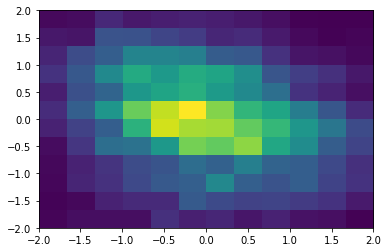

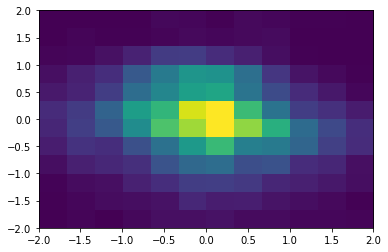

In [82]:
IPM2_X = (I.ipm2_xpos - I.ipm2_xpos.mean())/I.ipm2_xpos.std()
XDS_X  = (I.incident_beam_x - I.incident_beam_x.mean())/I.incident_beam_x.std()
_ = plt.hist2d(IPM2_X, XDS_X, 12, ((-2, 2), (-2, 2)))

np.corrcoef(IPM2_X, XDS_X)[0,1]

plt.figure()
IPM2_Y = (I.ipm2_ypos - I.ipm2_ypos.mean())/I.ipm2_ypos.std()
XDS_Y  = (I.incident_beam_y - I.incident_beam_y.mean())/I.incident_beam_y.std()
_ = plt.hist2d(IPM2_Y, XDS_Y, 12, ((-2, 2), (-2, 2)))

np.corrcoef(IPM2_Y, XDS_Y)[0,1]

In [83]:
keepcols = [
    'H',
    'K',
    'L',
    'MERGEDH',
    'MERGEDK',
    'MERGEDL',
    'IOBS',
    'SIGMA(IOBS)',
    'ipm2',
    'ipm3',
    'ipm2_xpos',
    'ipm3_xpos',
    'ipm2_ypos',
    'ipm3_ypos',
    'RUN',
    'PHINUMBER',
    'SERIES'
]

I = I[[i for i in keepcols]]


In [84]:
print("Number of reflection observations: {}".format(len(I)))
print("Multiplicity: {}".format(len(I)/len(I.groupby(['H', 'K', 'L']))))

#This removes reflections which were not observed in the 'on' and 'off' datasets at a given rotation
#This line is hilariously slow and should be sped up at some point. 
I = I.groupby(['H', 'K', 'L', 'RUN', 'PHINUMBER']).filter(lambda x: x.SERIES.str.contains('on').max() and x.SERIES.str.contains('off').max())

gammaobs = len(I.groupby(['H', 'K', 'L', 'RUN', 'PHINUMBER']))
gammamult = gammaobs / len(I.groupby(['H', 'K', 'L']))
print("Number of gamma observations: {}".format(gammaobs))
print("Multiplicity: {}".format(gammamult))

Number of reflection observations: 671792
Multiplicity: 20.60585240169315
Number of gamma observations: 86685
Multiplicity: 3.4180434525452466


In [85]:
"""
#########################################################
It is important to establish some numerical indices in 
order to index arrays in the optimization problem. 

----------
GAMMAINDEX
----------
    A unique numeric index is assigned to each combination
    of H, K, and L. This index uses the "MERGEDH/K/L" 
    attributes in the dataframe. This way we don't estimate
    more gammas than are truly necessary. This should not be
    used for grouping observations to make ratiometric 
    observations, because it will group together equivalent
    observations in a single image should they exist. That
    would be problematic, because equivalent observations will
    certainly not have the same partiality.

--------
RUNINDEX
--------
    A unique, sequential identifier for each run/crystal.
    Use this for indexing per crystal parameters.

----------
IMAGEINDEX
----------
    A unique, sequential identifier for each image in the 
    dataset. Use this for adding per shot parameters. 

--------
PHIINDEX
--------
    A unique, sequential identifier for each group of shots
    on the same crystal at the same rotation angle. 


#########################################################
"""

indices = {
    'GAMMAINDEX' : ['MERGEDH', 'MERGEDK', 'MERGEDL'], 
    'RUNINDEX'   : 'RUN', 
    'IMAGEINDEX' : ['RUN', 'PHINUMBER', 'SERIES'],
    'PHIINDEX'   : ['RUN', 'PHINUMBER'],
}

for k,v in indices.items():
    I[k] = I.groupby(v).ngroup()

In [86]:

k = [i for i in I if 'ipm' in i.lower()]
k += ['RUNINDEX']#, 'Io']
imagemetadata = I[k + ['IMAGEINDEX']].groupby('IMAGEINDEX').mean()
imagemetadata['IPM']   = imagemetadata['ipm{}'.format(ipm_number)]
imagemetadata['IPM_X'] = imagemetadata['ipm{}_xpos'.format(ipm_number)]
imagemetadata['IPM_Y'] = imagemetadata['ipm{}_ypos'.format(ipm_number)]
imagemetadata

,ipm2,ipm3,ipm2_xpos,ipm3_xpos,ipm2_ypos,ipm3_ypos,RUNINDEX,IPM,IPM_X,IPM_Y
IMAGEINDEX,,,,,,,,,,
0,0.254835,0.275872,-0.018381,0.018735,0.136058,0.591125,0,0.254835,-0.018381,0.136058
1,0.218671,0.233680,-0.012491,0.015180,0.127141,0.594573,0,0.218671,-0.012491,0.127141
2,0.175869,0.190726,-0.030969,0.006084,0.116510,0.613592,0,0.175869,-0.030969,0.116510
3,1.123760,1.193244,-0.027488,0.006590,0.130279,0.588278,0,1.123760,-0.027488,0.130279
4,0.494249,0.532147,-0.023908,0.006495,0.131232,0.593146,0,0.494249,-0.023908,0.131232
5,0.468995,0.508724,-0.012981,0.014155,0.138520,0.601169,0,0.468995,-0.012981,0.138520
6,0.344253,0.375971,-0.016441,0.017851,0.119454,0.591636,0,0.344253,-0.016441,0.119454
7,0.168316,0.188972,-0.026316,0.012817,0.142453,0.590390,0,0.168316,-0.026316,0.142453
8,0.159466,0.174018,-0.026935,0.007367,0.125178,0.606651,0,0.159466,-0.026935,0.125178


In [87]:
iobs        = I.pivot_table(values='IOBS', index=['H', 'K', 'L', 'RUNINDEX','PHIINDEX'], columns='SERIES', fill_value=np.NaN) 
imagenumber = I.pivot_table(values='IMAGEINDEX', index=['H', 'K', 'L', 'RUNINDEX', 'PHIINDEX'], columns='SERIES', fill_value=-1)
ion    = iobs[[i for i in iobs if  'on' in i]].sum(1) 
ioff   = iobs[[i for i in iobs if 'off' in i]].sum(1)
gammas = ion / ioff

gammaidx = I.pivot_table(values='GAMMAINDEX', index=['H', 'K', 'L', 'RUNINDEX','PHIINDEX'])
gammaidx = np.array(gammaidx).flatten()

sigma       = I.pivot_table(values='SIGMA(IOBS)', index=['H', 'K', 'L', 'RUNINDEX','PHIINDEX'], columns='SERIES', fill_value=np.NaN) 
sigmaion    = np.sqrt(np.square(iobs[[i for i in iobs if  'on' in i]]).sum(1))
sigmaioff   = np.sqrt(np.square(iobs[[i for i in iobs if 'off' in i]]).sum(1))
sigmagamma  = np.abs(gammas)*np.sqrt(np.square(sigmaion / ion) + np.square(sigmaioff / ioff))
mergingweights = (1. / np.array(sigmagamma, dtype=float32)) * ((1./np.array([(1./sigmagamma.iloc[gammaidx == i]).sum() for i in range(gammaidx.max() + 1)], dtype=float32))[gammaidx])

H = np.array(I.groupby('GAMMAINDEX').mean()['MERGEDH'], dtype=int)
K = np.array(I.groupby('GAMMAINDEX').mean()['MERGEDK'], dtype=int)
L = np.array(I.groupby('GAMMAINDEX').mean()['MERGEDL'], dtype=int)

FOBS = np.array(R.loc[zip(H, K, L), 'FOBS'])
FOBS[np.isnan(FOBS)] = 0

/n/home04/kmdalton/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


In [91]:
tf.reset_default_graph()
h = gammaidx.max() + 1

r = len(gammas.reset_index().groupby('RUNINDEX'))
runidx = np.array(imagemetadata['RUNINDEX'])
epsilon = 0.0


#We need two sparse tensors to map from Icryst estimates into the liklihood function. 
#First the 'on' shots
tmp = np.array(imagenumber[[i for i in imagenumber if 'on' in i]])
idx = np.vstack((np.indices(tmp.shape)[0][tmp >= 0], tmp[tmp >= 0])).T
onimageidx = tf.SparseTensor(idx, np.ones(len(idx), dtype=np.float32), (len(imagenumber), len(imagemetadata)))
onimageidx = tf.sparse_reorder(onimageidx)

#Now the 'off' shots
tmp = np.array(imagenumber[[i for i in imagenumber if 'off' in i]])
idx = np.vstack((np.indices(tmp.shape)[0][tmp >= 0], tmp[tmp >= 0])).T
offimageidx = tf.SparseTensor(idx, np.ones(len(idx), dtype=np.float32), (len(imagenumber), len(imagemetadata)))
offimageidx = tf.sparse_reorder(offimageidx)

#Let us have a sparse matrix for averaging hkl observations
idx = np.vstack((
    gammaidx,
    np.arange(len(gammaidx), dtype=int), 
)).T
tshape = (
    gammaidx.max()+1,
    len(gammaidx), 
)
#vals = np.array((1./sigmagamma).groupby(['MERGEDH', 'MERGEDK', 'MERGEDL']), dtype=float32)[gammaidx] / np.array(sigmagamma, dtype=float32)
vals = mergingweights
mergingtensor = tf.SparseTensor(idx, vals, tshape)
mergingtensor = tf.sparse_reorder(mergingtensor)



#Constants 
raw_gammas = tf.constant(np.float32(gammas))
ipm        = tf.constant(np.float32(imagemetadata['IPM']))
ipm_x      = tf.constant(np.float32(imagemetadata['IPM_X']))
ipm_y      = tf.constant(np.float32(imagemetadata['IPM_Y']))
F          = tf.constant(np.float32(FOBS))

#Regularization strength
#rho = tf.placeholder(tf.float32)

#LCs for scaling IPM data
#x_slope_ = 5000.
x_intercept   = tf.constant(imagemetadata.IPM_X.mean())
x_slope       = tf.constant(1./imagemetadata.IPM_X.std())
y_intercept   = tf.constant(imagemetadata.IPM_Y.mean())
y_slope       = tf.constant(1./imagemetadata.IPM_Y.std())
ipm_intercept = tf.Variable(0.0)
ipm_slope     = tf.constant(1.)
#ipm_slope     = tf.constant(1.)

#Beam shape
sigx          = tf.constant(50.)
sigy          = tf.constant(50.)
#sigx          = tf.Variable(100.)
#sigy          = tf.Variable(100.)

#Crystal dimensions
xpos = tf.Variable(np.zeros(r, dtype=np.float32))
ypos = tf.Variable(np.zeros(r, dtype=np.float32))
width  = tf.Variable(np.sqrt(100.)*np.ones(r, dtype=np.float32))
height = tf.Variable(np.sqrt(100.)*np.ones(r, dtype=np.float32))
xmin   = xpos - 0.5*tf.square(width)
xmax   = xpos + 0.5*tf.square(width)
ymin   = ypos - 0.5*tf.square(height)
ymax   = ypos + 0.5*tf.square(height)
#xmin          = tf.Variable(-50.*np.ones(r, dtype=np.float32))
#xmax          = tf.Variable( 50.*np.ones(r, dtype=np.float32))
#ymin          = tf.Variable(-50.*np.ones(r, dtype=np.float32))
#ymax          = tf.Variable( 50.*np.ones(r, dtype=np.float32))

#gammastimates
gamma         = tf.Variable(np.ones(h), dtype=np.float32)

beamx  = ipm_x * x_slope + x_intercept
beamy  = ipm_y * y_slope + y_intercept


Icryst = 0.25*(ipm_slope*ipm + ipm_intercept) * (
    tf.erf((tf.gather(xmin, runidx) - beamx)/sigx) - tf.erf((tf.gather(xmax, runidx) - beamx)/sigx)
    ) * (
    tf.erf((tf.gather(ymin, runidx) - beamy)/sigy) - tf.erf((tf.gather(ymax, runidx) - beamy)/sigy)
    )

Bon  = tf.squeeze(tf.sparse_tensor_dense_matmul( onimageidx, tf.expand_dims(Icryst, 1)))
Boff = tf.squeeze(tf.sparse_tensor_dense_matmul(offimageidx, tf.expand_dims(Icryst, 1)))


#g = tf.maximum(raw_gammas*Boff/Bon, 0.)
#g = raw_gammas*Boff/(Bon + epsilon)
g = tf.squeeze(tf.sparse_tensor_dense_matmul(mergingtensor, tf.expand_dims(raw_gammas*Boff/(Bon + epsilon), 1)))
#deltaF = tf.sqrt(g) - 1.
deltaFoverF = (tf.sqrt(g) - 1.)
#deltaFoverF = tf.squeeze(tf.sparse_tensor_dense_matmul(mergingtensor, tf.expand_dims(deltaFoverF_unmerged, 1)))
deltaF = F*deltaFoverF
loss = tf.reduce_sum(tf.abs(deltaF))

0: 165825.65625
100: 164445.96875
200: 164194.078125
300: 163839.9375
400: 163497.59375
500: 163154.984375
600: 162833.84375
700: 162486.75
800: 162127.90625
900: 161778.234375
1000: 161391.78125
1100: 161022.296875
1200: 160621.359375
1300: 160248.203125
1400: 159851.84375
1500: 159457.71875
1600: 159083.21875
1700: 158734.171875
1800: 158406.359375
1900: 158068.03125
2000: 157706.046875
2100: 157335.984375
2200: 157000.90625
2300: 156677.828125
2400: 156358.21875
2500: 156020.4375
2600: 155698.046875
2700: 155386.59375
2800: 155084.390625
2900: 154795.34375
3000: 154519.578125
3100: 154244.0625
3200: 154011.96875
3300: 153732.078125
3400: 153464.15625
3500: 153266.125
3600: 153058.78125
3700: 153002.546875
3800: 152833.984375
3900: 152762.375
4000: 152606.0625
4100: 152531.203125
4200: 152435.9375
4300: 152358.0625
4400: 152299.78125
4500: 152265.140625
4600: 152148.3125
4700: 152074.328125
4800: 152037.734375
4900: 151909.4375
5000: 151901.109375
5100: 151995.875
5200: 152034.8125
5

No handles with labels found to put in legend.


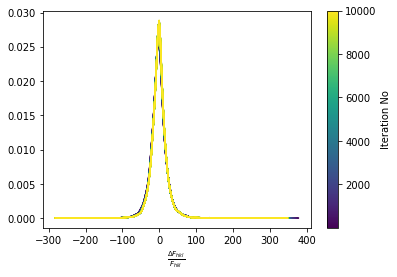

<Figure size 432x288 with 0 Axes>

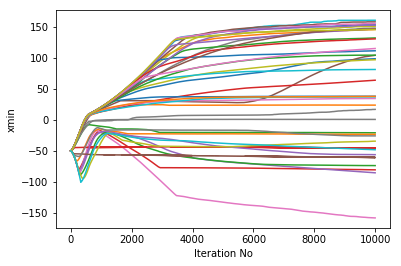

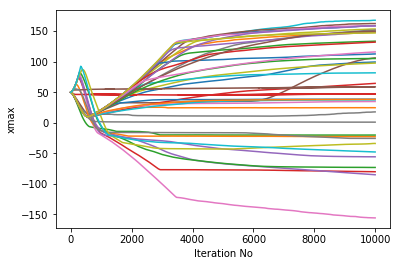

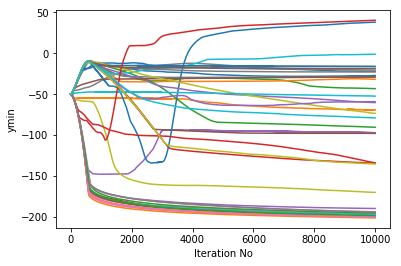

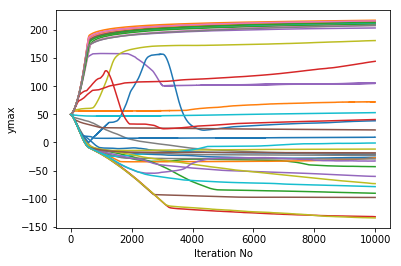

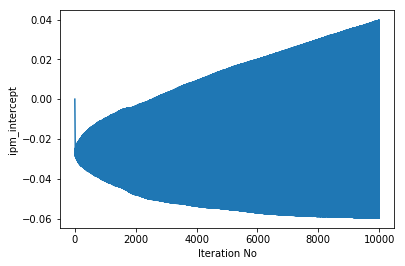

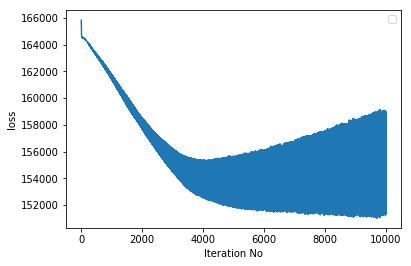

In [105]:
from tensorflow.contrib.opt import ScipyOptimizerInterface

var_groups = {
    'IPM Intercept' : ipm_intercept,
    'Crystal Dims'  : [xmin, xmax, ymin, ymax],
}

#optimizers = {k:tf.train.AdagradOptimizer(0.5).minimize(loss, var_list=v) for k,v in var_groups.items()}
#optimizer = tf.train.AdagradOptimizer(.05).minimize(loss)
#optimizer = tf.train.AdamOptimizer(.01).minimize(loss)
optimizer = tf.train.AdadeltaOptimizer(10., .01).minimize(loss)
bfgsoptimizer = ScipyOptimizerInterface(loss)



nsteps = 10000
verbose=False
cmap = plt.get_cmap()
norm = plt.Normalize(vmin=1., vmax=nsteps)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array((1., nsteps))



logvars = {
    'xmin': xmin,
    'xmax': xmax,
    'ymin': ymin,
    'ymax': ymax,
    #'sigx': sigx,
    #'sigy': sigy,
    #'Icryst': Icryst,
    #'ipm_slope' : ipm_slope, 
    #'Bon' : Bon,
    #'Boff': Boff,
    #'x_slope' : x_slope, 
    #'y_slope' : y_slope, 
    #'gamma' : g,
    #'deltaF unmerged': deltaF_unmerged,
    #'deltaF' : deltaF,
    'ipm_intercept' : ipm_intercept, 
    'loss' : loss,
    #'regularizer' : regularizer,
    #'absolute_deviation' : absolute_deviation,
}

L = {k:[] for k in logvars}
#L['loss'] = []
deltaF_ = None
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for k,v in logvars.items():
        L[k].append(sess.run(v))
    print("0: {}".format(L['loss'][-1]))
    #bfgsoptimizer.minimize(sess)
    for i in range(nsteps):
        _,loss_ = sess.run((optimizer, loss))
        #for k,v in optimizers.items(): #sess.run(v)
        for k,v in logvars.items():
            L[k].append(sess.run(v))
        if np.isnan(L['loss'][-1]):
            for k,v in logvars.items():
                L[k].append(sess.run(v))
            break
        #print("{}: {}".format(i+1, L['loss'][-1]))
        deltaF_ = sess.run(deltaF)
        if (i + 1) % 100 == 0:
            print("{}: {}".format(i+1, L['loss'][-1]))
            x1, x2  = deltaF_.min(),deltaF_.max()
            X = np.linspace(x1 - 0.1*(x2 - x1), x2 + 0.1*(x2 - x1), 200)
            plt.plot(X, gaussian_kde(deltaF_)(X), c=sm.to_rgba(i+1))
    bfgsoptimizer.minimize(sess)
        
        

plt.colorbar(sm, ax=plt.gca(), label='Iteration No')
plt.xlabel(r'$\frac{\Delta F_{hkl}} {F_{hkl}}$')

plotvars = ['xmin', 'xmax', 'ymin', 'ymax', 'ipm_intercept', 'loss']

plt.figure()
for k in plotvars:
    v = L[k]
    plt.figure()
    plt.plot(v)
    plt.ylabel(k)
    plt.xlabel('Iteration No')
plt.legend()

median: -1.0290504693984985
  mean: -0.8098769783973694


(-100, 100)

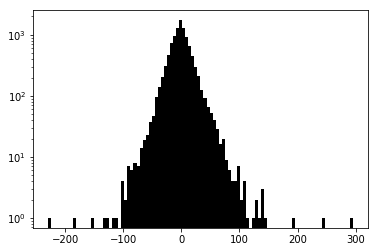

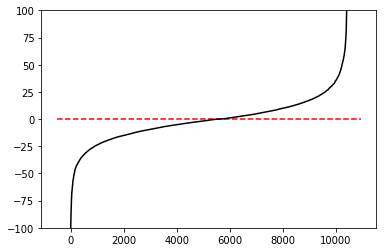

In [107]:
_ = hist(deltaF_, 100, color='k')
plt.semilogy()
print("median: {}".format(median(deltaF_)))
print("  mean: {}".format(mean(deltaF_)))
plt.figure()
plt.plot(np.sort(deltaF_), '-k')
plt.hlines([0], *plt.xlim(), 'r', '--')
plt.ylim(-100, 100)

In [100]:
H = np.array(I.groupby('GAMMAINDEX').mean()['MERGEDH'], dtype=int)
K = np.array(I.groupby('GAMMAINDEX').mean()['MERGEDK'], dtype=int)
L = np.array(I.groupby('GAMMAINDEX').mean()['MERGEDL'], dtype=int)

O = R.loc[zip(H, K, L)]
O['DeltaF'] = deltaF_
O = O.dropna()
O._coerce_dtypes()
O

/n/home04/kmdalton/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """


FOBS         D       PHASE  MERGEDH  MERGEDK  MERGEDL  \
H  K   L                                                               
0  -17 18  190.3050  1.883403  177.305000        0       17       18   
       20  296.9320  1.857767    0.374707        0       17       20   
   -16 14   33.8822  2.039794 -171.083000        0       16       14   
       15   86.9260  2.027226   95.134400        0       16       15   
       16  332.5170  2.014044    3.109230        0       16       16   
       18  187.4890  1.986008    0.713235        0       16       18   
       21  271.3760  1.940393  -88.037800        0       16       21   
   -15 13   31.3979  2.177516 -107.614000        0       15       13   
       18  206.1960  2.099442  178.438000        0       15       18   
       21  138.3260  2.045772  -92.518000        0       15       21   
   -14 10   32.2582  2.364586  164.868000        0       14       10   
       11  199.4460  2.350404  -86.417600        0       14       11   
       14   16.7112  2.301765    8.305120        0       14       14   
       20  343.5320  2.183351    0.785979        0       14       20   
       22  408.8840  2.139639  178.994000        0       14       22   
       25  193.1240  2.071821   93.056900        0       14       25   
   -13 9   100.0690  2.550935   93.144000        0       13        9   
       10  335.0960  2.534833  179.335000        0       13       10   
       12  145.1410  2.498686 -178.002000        0       13       12   
       13  119.9260  2.478824  -84.033600        0       13       13   
       15  228.4690  2.435998  -81.267300        0       13       15   
       22  502.4740  2.263302 -177.662000        0       13       22   
       23  175.3570  2.236883  -90.349100        0       13       23   
       24  189.1560  2.210253    0.498364        0       13       24   
       26   37.4444  2.156620  166.212000        0       13       26   
       29  413.5870  2.076068   92.215000        0       13       29   
       30  246.2720  2.049382 -179.756000        0       13       30   
       36  430.2170  1.893488   -1.424270        0       13       36   
       39  232.1420  1.819355  -88.045200        0       13       39   
   -12 7   700.6810  2.785548  -89.693400        0       12        7   
...             ...       ...         ...      ...      ...      ...   
19  5  20  373.9390  2.038669   86.497100       19        5       20   
    6  1   290.1910  2.188219 -171.051000       19        6        1   
       2   330.9380  2.186575  151.097000       19        6        2   
    7  7   144.2090  2.108192  -40.552400       19        7        7   
20 -7  8   177.4880  2.017189  -36.280600       20        7        8   
       11  134.2530  1.993437   61.560100       20        7       11   
   -2  8   264.1120  2.197607  -31.164800       20        2        8   
       12  235.3810  2.155008  148.708000       20        2       12   
   -1  10  254.2780  2.191575  154.225000       20        1       10   
       13  199.4480  2.154995   96.235100       20        1       13   
    0  2   239.3800  2.250711  180.000000       20        0        2   
       13  198.6680  2.159311  180.000000       20        0       13   
    1  10  254.2780  2.191575  154.225000       20        1       10   
    3  8   175.9040  2.175141  154.010000       20        3        8   
    4  6   226.2520  2.159248  -31.352400       20        4        6   
       10  194.8020  2.126688  135.530000       20        4       10   
    5  18  279.5740  1.992156 -117.010000       20        5       18   
       23  190.6790  1.913442   50.523000       20        5       23   
    6  5   327.5610  2.082687 -176.529000       20        6        5   
    7  7   158.3020  2.023586 -107.414000       20        7        7   
       11  134.2530  1.993437   61.560100       20        7       11   
    8  13  244.9860  1.926265   61.274100       20        8       13   
21 -5  6   156.1720  2.031046  178.143000       21     

In [101]:
reflections = []
for (h,k,l), D in O.iterrows():
    reflections.append("INDE {} {} {} FOBS= {} {}\n".format(h,k,l,D['DeltaF'],D['PHASE']))
    
#header = ''.join([i for i in open(referenceData) if i[:4]!='INDE'])
header = """{ sg=P2(1) a=45.062 b=34.102 c=98.495 alpha=90 beta=90.03 gamma=90 }
NREFlections=1034
ANOMalous=FALSE
DECLare NAME=FOBS DOMAin=RECIprocal TYPE=COMPLEX END
"""

header = re.sub(r"(?<=NREFlections\=)[0-9]+", str(len(reflections)), header)
print(header)

with open(outFN, 'w') as out:
    out.write(header)
    out.write(''.join(reflections))

{ sg=P2(1) a=45.062 b=34.102 c=98.495 alpha=90 beta=90.03 gamma=90 }
NREFlections=10317
ANOMalous=FALSE
DECLare NAME=FOBS DOMAin=RECIprocal TYPE=COMPLEX END



"\nO.loc[np.abs(O['DeltaF']) < np.percentile(np.abs(O['DeltaF']), highpass), 'DeltaF'] = 0.\nplt.figure()\nplt.scatter(O['D'], O['DeltaF'], edgecolors='k', facecolors='none', alpha=0.05)\nplt.figure()\nplt.scatter(O['FOBS'], O['DeltaF'], edgecolors='k', facecolors='none', alpha=0.05)\n"

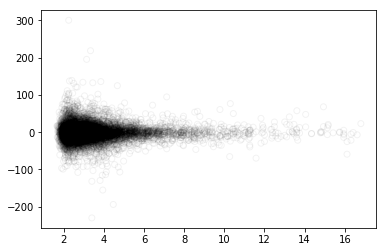

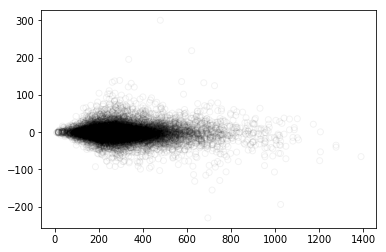

In [96]:
#highpass=99.9

plt.figure()
plt.scatter(O['D'], O['DeltaF'], edgecolors='k', facecolors='none', alpha=0.05)
plt.figure()
plt.scatter(O['FOBS'], O['DeltaF'], edgecolors='k', facecolors='none', alpha=0.05)

"""
O.loc[np.abs(O['DeltaF']) < np.percentile(np.abs(O['DeltaF']), highpass), 'DeltaF'] = 0.
plt.figure()
plt.scatter(O['D'], O['DeltaF'], edgecolors='k', facecolors='none', alpha=0.05)
plt.figure()
plt.scatter(O['FOBS'], O['DeltaF'], edgecolors='k', facecolors='none', alpha=0.05)
"""

In [ ]:
plt.scatter(O['FOBS'], O['FOBS'] + O['DeltaF'], edgecolors='k', facecolors='none', alpha=0.05)
plt.xlabel(r"$F_{hkl}^{OFF}$")
plt.ylabel(r"$F_{hkl}^{ON}$")